In [1]:
%matplotlib inline

# Using fastdb_client

This example is for running in Perlmutter.  You may be able to easily convert it for somewhere else.

Note that this example notebook was built when `fastdb-rknop-dev.lbl.gov` had the ELAsTiCC2 data loaded into it.  It's possible at some later time that you will not get the same results.  When a more stable version of fastdb exists, I will update this example notebook.

## What is fastdb_client

It's a python program useful for connecting to instances of FASTDB.  At some level, it's just a wrapper around python `requests`, but it handles some other stuff you wouldn't want to handle manually.  For example, logging into FASTDB is not just a matter of sending a password over the net, but is a complicated handshaking of public key cryptography (created by somebody trying to be paranoid to make sure the password itself never needed to be sent over the network from your machine to the server machine).  The fastdb_client takes care of all of that for you.  It has the ability to do some format parsing of responses from the web server.  Finally, it has a built-in "sleep and retry" cycle, where if the connection to the FASTDB server fails for some reason (which does happen--- this is the Internet, after all), it will sleep a few seconds and retry, repeating that (by default) five times before giving up for good.  This can greatly increase the reliability of scripts that use the fastdb_client, saving you from having to implement your own error catching and retry loop.

## Getting an account

To use FASTDB, you need an account on the instance of the FASTDB web server you want to interact with.  As of this writing, the only one that exists is `https://fastdb-rknop-dev.lbl.gov`, and as its name suggests, it's a development server that may be down at any time, or that may have unexpected changes of contents and state at any time.  To get an account, ask Rob Knop (via Discovery Alliance Slack) for an account; I will need the username you want for the account, the name you want displayed when you are logged in, and the email address associated with the account.  Once I tell you the account is created, go to the webserver in your browser, and click on "Request Password Reset".  Put in your username, and click "Email Password Resent Link".  Shortly thereafter, in your email you should find a message with a link to click on to reset your password.  (When your account is first created, it does not have a password; you can not log into it until you set one.)

Make sure to choose a <a href="http://rknop.net/password.html">good password</a>.  FASTDB is currently not using any TFA, and I'm really hoping we won't feel the need to go that way, as that will make a lot of life a lot more complicated.

### Setting up a convenience initialization file

You can always just use the url, username, and password every time you connect to fastdb.  However, it will probably make your life easier if you create a file `.fastdb.ini` (notice the period at the beginning) in your home directory.  This file will have contents like:

```
[rknop-dev]
url = https://fastdb-rknop-dev.lbl.gov
username = <your username>
password = <your password>

[production]
url = https://desc-fastdb.lbl.gov
username = <your username>
password = <your password>
```

Each block of lines starting with a line in brackets represents one FASTDB server you might want to connect to.  The name in brackets can be whatever you want; it will be wha tyou use in order to specify the server you want to conenct to.  Below each bracketed line, you need three lines, similar to the example above, which specify the URL of the web server, your username on that server, and your password on that server.  (As of this writing you do not want to include the `[production]` block because that server does not exist.)

**Important**: the fastdb client will refuse to use this `.ini` file if it's permissions aren't sufficiently paranoid.  After you've created the file, run
```
cd
chmod go -rwx .fastdb.ini
```
to make sure that only you can read it.

There are actually a number of other configuration options you can specify here, but for now they're not that important.  Talk to Rob, or read the `fastdb_client.py` source code if you're interested.

## Setting up your environment

`fastdb_client.py` requires libraries that are not yet in the standard desc time domain environment.  However, they are in the current dev environment.  On Perlmutter, you can get yourself in this environment with
```
source $CFS/lsst/groups/TD/setup_td_dev.sh
```

### Running from jupyter

Make sure to select the `desc-td-env-dev` kernel.  If that kernel isn't available, you can create it on Perlmutter with:
```
cd ~/.local/share/jupyter/kernels
mkdir desc-td-env-dev
```

In this directory, create two files.  The first one is named `td-env-dev.sh` and has conents:
```
#!/bin/bash

INST_DIR=/global/cfs/cdirs/lsst/groups/TD
source $INST_DIR/setup_td_dev.sh -k -c

if [ $# -gt 0 ] ; then
    exec python -m ipykernel $@
fi
```

the second one is `kernel.json` and has contents:
```
{
  "argv": [
    "/global/common/software/lsst/common/miniconda/kernels/td-env-dev.sh",
    "-f",
    "{connection_file}"
  ],
  "display_name": "desc-td-env-dev",
  "language": "python"
}
```


In [2]:
# The FastDB client can be found on Perlmutter in the directory
#   /global/cfs/cdirs/lsst/groups/TD/SOFTWARE/fastdb_deployment/fastdb_client
# (The client there is actually a symbolic link to something else underneath
# fastdb_deployment.  If you know what you're doing, you may want to use a
# version of the client other than the one there, but by default that's the
# right one to use.)  Put this directory in your PYTHONPATH so it will be found.
import sys
sys.path.insert( 0, '/global/cfs/cdirs/lsst/groups/TD/SOFTWARE/fastdb_deployment/fastdb_client' )

#...and import!
from fastdb_client import FASTDBClient

# Also import other stuff we'll need
import io
import time
import pandas
import json
from matplotlib import pyplot


In [3]:
# Create your connection to fastdb.  This will log you in.
#
# There are two ways to do this.
# You can always just specify the url, username, and password, with 
#   something like:
#      fdb = FASTDBClient( 'https://fastdb-rknop-dev.lbl.gov', 'rknop', 'not_really_robs_password' )
#   where the three arguments are url, username, and password.  BE CAREFUL PUTTING PASSWORDS IN SCRIPTS,
#   and NEVER commit a script that has a password in it to a git archive anywhere!  If you do, immmediately
#   change your password.
# The other alternative is just to use the name you set up in your ~/.fastdb.ini file (described above).
#   that's what I do here.

fdb = FASTDBClient( "rknop-dev" )

## WEB API Endpoints

You use the fastdb client to connect to web API endpoints on the server.  All of these will eventually be documented, but for now, here are some examples of endpoints that you can hit.

In [4]:
# /getprocvers lists all the known processing versions and processing version aliases. 
# (There are at most as many different processing versions as the list you get back,
# because one processing version may have multiple aliases.)
res = fdb.post( "/getprocvers" )
print( res )

{'status': 'ok', 'procvers': ['realtime']}


In [5]:
# You can get the lightcurve for an object if you know it's object ID with the /ltcv/getltcv 
# endpoint.  Give it the processing version and the diaobjectid as additional slash-separated
# url components.
t0 = time.perf_counter()
ltcvdict = fdb.post( "/ltcv/getltcv/realtime/5181140" )
print( f"/ltcv/getltcv took {time.perf_counter()-t0:.2f} seconds" )

# The dictionary you get back has keys 'status', 'objectinfo' and 'ltcv':
print( f"Got back ltcvdict with keys {ltcvdict.keys()}" )

objinfo = { k: v for k, v in ltcvdict.items() if k != 'ltcv' }
print( f"Object info: {json.dumps( objinfo, indent=4 )}" )

ltcv = pandas.DataFrame( ltcvdict['ltcv'] )
ltcv

/ltcv/getltcv took 0.69 seconds
Got back ltcvdict with keys dict_keys(['ltcv', 'diaobjectid', 'radecmjdtai', 'validitystart', 'validityend', 'ra', 'raerr', 'dec', 'decerr', 'ra_dec_cov', 'nearbyextobj1', 'nearbyextobj1id', 'nearbyextobj1sep', 'nearbyextobj2', 'nearbyextobj2id', 'nearbyextobj2sep', 'nearbyextobj3', 'nearbyextobj3id', 'nearbyextobj3sep', 'nearbylowzgal', 'nearbylowzgalsep', 'parallax', 'parallaxerr', 'pmra', 'pmraerr', 'pmra_parallax_cov', 'pmdec', 'pmdecerr', 'pmdec_parallax_cov', 'pmra_pmdec_cov', 'rootid', 'base_procver_id'])
Object info: {
    "diaobjectid": 5181140,
    "radecmjdtai": 61671.367,
    "validitystart": null,
    "validityend": null,
    "ra": 30.442935383312722,
    "raerr": null,
    "dec": -30.535688889737266,
    "decerr": null,
    "ra_dec_cov": null,
    "nearbyextobj1": 8750110234,
    "nearbyextobj1id": "f0c3a742-df7d-4bc6-ba17-e7ebecafb46a",
    "nearbyextobj1sep": 0.33319703,
    "nearbyextobj2": null,
    "nearbyextobj2id": null,
    "nearbye

,visit,mjd,band,flux,fluxerr,isdet,ispatch
0,1223848222,61192.4111,z,1260.143100,1053.7013,0,0
1,1223968366,61198.4183,z,242.518360,734.2954,0,0
2,1223968582,61198.4291,Y,2645.191700,1485.7095,0,0
3,1224327984,61216.3992,i,-317.903750,622.8550,0,0
4,1224428410,61221.4205,Y,16.699959,1142.3867,0,0
...,...,...,...,...,...,...,...
284,1236880142,61844.0071,z,-755.588100,1307.2695,0,0
285,1236959892,61847.9946,z,-760.066650,2444.9230,0,0
286,1236959954,61847.9977,z,-1882.978300,1955.9896,0,0
287,1236960016,61848.0008,z,-344.120760,1371.1421,0,0


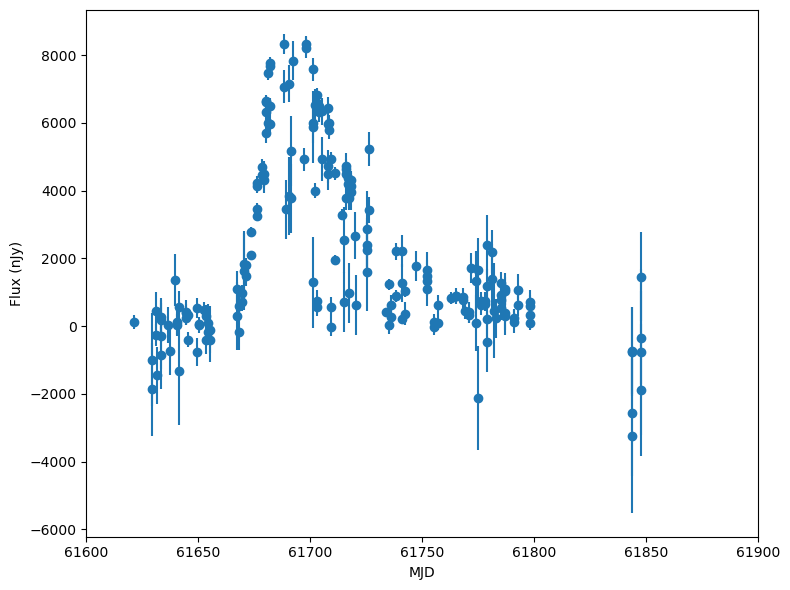

In [11]:
fig = pyplot.figure( figsize=(8,6), layout='tight' )
ax = fig.add_subplot( 1, 1, 1 )
ax.errorbar( ltcv.mjd, ltcv.flux, ltcv.fluxerr, linestyle='none', marker='o' )
ax.set_xlabel( "MJD" )
ax.set_ylabel( "Flux (nJy)" )
ax.set_xlim( 61600, 61900 )
fig.show()
pyplot.show()

In [24]:
# You can search for lightcurves with /objectsearch/<procver>
# This one requires you to pass some search data as a dict:

res = fdb.post( "/objectsearch/realtime", json={"ra": 30.5, "dec": -30.5, "radius": 300.} )
objs = pandas.DataFrame(res)
objs

,diaobjectid,ra,dec,numdet,firstdetmjd,firstdetband,firstdetflux,firstdetfluxerr,lastdetmjd,lastdetband,...,lastdetfluxerr,maxdetmjd,maxdetband,maxdetflux,maxdetfluxerr,lastforcedflux,lastforcedfluxerr,lastforcedmjd,lastforcedband,numdetinwindow
0,3078685,30.504102,-30.468295,4,61019.1218,r,1246.23050,124.560715,61047.0787,z,...,432.516663,None,None,None,None,-878.219540,1255.8085,61848.0039,z,None
1,5181140,30.442935,-30.535689,66,61671.3658,r,1811.29610,209.658450,61688.3090,i,...,299.537903,None,None,None,None,1460.280800,1307.4806,61848.0039,z,None
2,14575827,30.429702,-30.555372,15,61289.3958,r,2010.74660,153.849040,61303.2115,r,...,157.686188,None,None,None,None,1642.706800,1266.0607,61848.0039,z,None
3,21210588,30.534929,-30.516359,1,61776.1059,i,855.42596,361.082030,61776.1059,i,...,361.082031,None,None,None,None,-93.964180,1430.1960,61848.0039,z,None
4,45314436,30.462446,-30.557761,2,60918.4163,r,1561.68930,256.989700,60918.4163,r,...,256.989685,None,None,None,None,-174.183600,1282.2511,61848.0039,z,None
5,61834508,30.567793,-30.520655,6,61709.2639,r,1453.29740,227.173250,61717.2623,z,...,379.583557,None,None,None,None,-673.644700,1348.5437,61848.0039,z,None
6,67331748,30.475023,-30.448624,4,61763.1237,r,799.94324,166.602110,61768.1214,i,...,240.533798,None,None,None,None,-2236.261700,1293.6123,61848.0039,z,None
7,88470010,30.554329,-30.440195,6,61019.1218,r,3175.97050,171.733230,61039.0834,Y,...,823.722229,None,None,None,None,226.745380,1299.5165,61848.0039,z,None
8,98910793,30.521204,-30.566114,4,60993.3072,g,662.04880,201.873410,61002.1912,i,...,247.987732,None,None,None,None,1141.032700,1246.9432,61848.0039,z,None
9,100589617,30.417672,-30.463657,6,61316.3091,r,1557.42800,185.300580,61328.1284,r,...,227.677856,None,None,None,None,-18.334728,1265.6128,61848.0039,z,None


## Direct SQL Queries

You can make make direct read-only queries to the PostgreSQL database behind the FASDTB webserver.  You construct queries and substitution dictionaries just like you'd send to `psycopg2`'s `cursor.execute` method.  (Use the `%(name)s` format for substitutions in your query, *not* the simple `%s` format where you'd pass a list as the second argument of `cursor.execute.)

There are two interfaces.  The "short" query interface is for queries that will complete in less than five minutes.  (This is actually not a database restriction, but a restriction of the web proxy in front of the FASTDB web server; it will time any connection out after five minutes.)  The "long" query interface is for longer queries.  It normally has a cycle of submitting a query, repeatingly checking to see if it's done, and then asking for the results.  However, the fastdb_client has a function that wraps all of that into one call that's as simple to use as the short SQL query.

For both interfaces, you can either pass a single query, or a list of queries.  If you pass a list of queries, you will only get the results from the *last* query.  If you want the results of multiple queries, send them each in individually.  The purpose of allowing multiple queries is so that you can play games with temporary tables and such while doing a complicated query.  If you past a list of queries, then you must also pass a list of substitution dictionaries that has the same length as your query list.

Using either interface requires you to understand the structures of the tables.  In particular, you need to undertand about `processing_version` and `snapshot`.  If you do not, and just look at columns in the `diaobject` and `diasource` tables, there is an excellent chance you will not get what you think you are getting.  See ROB PUT IN THE PLACE WHERE YOU DOCUMENT THE DATABASE SCHEMA AND STRUCTURE.

In [16]:
# The short query interface is for queries that take less than 5 minutes.
#
# If all is well, you get back either a list of dictionaries, or a dictionary of
# column→list, depending on how you call the short query interface.

# A quick example: let's get the 10 objects with the lowest diaobjectid.  (This isn't something that
# would usually be useful, but it's an easy example.)  (What's more, it's a misuse
# of FASTDB, because it's ignoring processing_version, which you should never do.)

res = fdb.submit_short_sql_query( "SELECT * FROM diaobject ORDER BY diaobjectid LIMIT 10" )
print( f"Got back a {type(res)} of length {len(res)}" )
print( f"The keys in the first element of the resonse are: {res[0].keys()}" )

Got back a <class 'list'> of length 10
The keys in the first element of the resonse are: dict_keys(['diaobjectid', 'processing_version', 'radecmjdtai', 'validitystart', 'validityend', 'ra', 'raerr', 'dec', 'decerr', 'ra_dec_cov', 'nearbyextobj1', 'nearbyextobj1id', 'nearbyextobj1sep', 'nearbyextobj2', 'nearbyextobj2id', 'nearbyextobj2sep', 'nearbyextobj3', 'nearbyextobj3id', 'nearbyextobj3sep', 'nearbylowzgal', 'nearbylowzgalsep', 'parallax', 'parallaxerr', 'pmra', 'pmraerr', 'pmra_parallax_cov', 'pmdec', 'pmdecerr', 'pmdec_parallax_cov', 'pmra_pmdec_cov'])


In [17]:
# While a list of dictionaries is sometimes convenient, it's also a wasteful format,
# as the JSON that's passed from server to client repeats all of the column names every
# single row.  You can also ask for a dictionary of columns to lists of values.
# Do this by passing return_format=1 to submit_short_sql_query.

res = fdb.submit_short_sql_query( "SELECT * FROM diaobject ORDER BY diaobjectid LIMIT 10", return_format=1 )
print( f"Got back a {type(res)} with {len(res.keys())} keys; res['diaobjectid'] has length {len(res['diaobjectid'])}" )
print( f"The diaobjectids returned are {', '.join([ str(i) for i in res['diaobjectid'] ])}" )

Got back a <class 'dict'> with 30 keys; res['diaobjectid'] has length 10
The diaobjectids returned are 1000052, 1000065, 1000111, 1000154, 1000155, 1000168, 1000283, 1000294, 1000296, 1000344


In [18]:
# You can pass variables when constructing your query. The query below is going to ask for all objects within
#   4 arcminutes of (RA, Dec) = (228°, 5.°) 
# The q3c_radial_query function is from the q3c postgres extension:
#   https://github.com/segasai/q3c
# A number of the tables have q3c indices defined for faster spatial querying.
#
# NOTE: as before, this is not acutally a query you'd ever want to do, because
#  it's totally ignoring processing_version.

query = "SELECT * FROM diaobject WHERE q3c_radial_query(ra,dec,%(ra)s,%(dec)s, %(rad)s)"
subs = { 'ra': 228., 'dec': 5., 'rad': 240./3600. }
res = fdb.submit_short_sql_query( query, subs, return_format=0 )
print( f"{len(res)} objects within {subs['rad']*60.:.2f} arcmin of ({subs['ra']:.5f}, {subs['dec']:.5f})" )

5 objects within 4.00 arcmin of (228.00000, 5.00000)


In [19]:
# Note that the data you get back both with `return_format=0` and `return_format=1`
# are suitable for direct import into a Pandas dataframe.
#
# (You will probably notice that most of the columns have "None" in them.  Some of
# that is because the table includes columns that had no corresponence in the 
# the SNANA simulations of ELAsTiCC2.)
df = pandas.DataFrame( res )
df


,diaobjectid,processing_version,radecmjdtai,validitystart,validityend,ra,raerr,dec,decerr,ra_dec_cov,...,nearbylowzgalsep,parallax,parallaxerr,pmra,pmraerr,pmra_parallax_cov,pmdec,pmdecerr,pmdec_parallax_cov,pmra_pmdec_cov
0,15157720,0,61552.105,None,None,228.015401,None,5.030694,None,None,...,None,None,None,None,None,None,None,None,None,None
1,85647835,0,61828.375,None,None,228.063170,None,4.987572,None,None,...,None,None,None,None,None,None,None,None,None,None
2,28724374,0,61222.066,None,None,227.999486,None,5.046197,None,None,...,None,None,None,None,None,None,None,None,None,None
3,114967799,0,61120.387,None,None,228.040880,None,4.968512,None,None,...,None,None,None,None,None,None,None,None,None,None
4,111922253,0,61475.324,None,None,228.027582,None,4.988687,None,None,...,None,None,None,None,None,None,None,None,None,None


### The long query interface

If your query is going to take more than 5 minutes, a call to `submit_short_sql_query` will time out.  (The backend database server will actually still be performing your query, but the web proxy will time out.)  FASTDB also has a system whereby you can submit a query (or a sequence of queries) to be run, but instead of the results, you get back a query id.  A job running on the backend server keeps track of which of these "long queries" have been submitted, and submits them in order, saving the results.  (The backend run several processes, so it can work on a handful of long queries at once.)  The normal way of using this long query interface is through the following methods of FASTDBClient:

* `submit_long_sql_query` : send the query and substitution dictionary (or queries and substitution dictionaries, if you want to send a sequence of queries and only get the results from the last one).  Get back an opaque string (called the "query id") that you will use to identify this query.
* `check_long_sql_query` : send the query id, get back a response from the server that tells you the state of the query.  It will tell you if the query is still queued, if it has started, if it errored out, or if it has finished.
* `get_long_sql_query_result` : only call this once `check_long_sql_query` tells you the query is finished.  Send the query id, get back the results.  The format of the results depends on the `return_format `parameter you passed to `submit_long_sql_query`.  Right now, only `return_format='csv'` is supported.  You will get back a string that is the contents of a CSV file with your query results.

Look at the dockstrings in `fastdb_client.py` for more information about using this interface.  Normally, you would save the returned query id somewhere, and every so often run a new script that sends that query id and looks for results.  However, there's an easier interface that works in a manner very similar to `submit_short_sql_query`, it just takes longer.

### An easier (but, of course, less flexible) way

The FASTDBClient method `synchronous_long_sql_query` will take care of all the calls above.  You call it with your query or queries, wait a long time, and get the results back.  In addition to the first two arguments (which are the query and substitution dictionary), you can pass a `return_format` (which defaults to `csv`, which is currently the only thing installed).  Two more parameters, `checkeach` (defaults to 300) and `maxwait` (defaults to 3600) tell it how often to check if your query is finished.  `checkeach` is the number of seconds to wait between checking if your query is finished.  It won't even check the first time before this much time has elapsed, so you know your call to `synchronous_long_sql_query` will take at least this long.  Please do not set `checkeach` to anything less than (say) 30 seconds.  (Indeed, if you're setting it to less than 300 seconds, there's an excellent chance you could just use the short sql query interface.)  After waiting `maxwait` seconds, it will give up altogether.  The reason to set this is if (for instance) the backend query runner has crashed; in that case, your query will languish in 'queuing mode' forever.  If you have confidence that the backend is working right, you can set `maxwait` to something huge, and eventually you will get back either the results of your query, or an execption will be raised if the query errored out.

In [20]:
# A more complicated example long query.  We're first going to look for all detections within a given MJD range.
# We'll then pull out lightcurves of all objects found in that MJD range.
# You could probably do this with a single long SQL query.  However, it's easier to think about this
# with multiple queries.  You *could* run the first query to get the object ids, and then send a second
# query where you pass all the object IDs.  However, that is not the most efficient way to do it; SQL
# queries where you have a long list in a WHERE ... IN(...) clause can be inefficient.  Instead, we're
# going to use a temporary table.  This also allows us to demonstrate sending a series of queries.
#
# We are using processing_version here, but normally you'd probably actually use snapshot rather than
# processing version, which would make this query more complicated.  Consider this an advertisement for
# web api endpoints.

subdict = { 'pv': 'elasticc2' }
queries = [
    # The first query is to the diasource table, which is a table of detections
    # The LIMIT and OFFSET here are because there's a N² scaling in the next query
    #   after this one.  By limiting ourselves to small nubmers of objects, we
    #   end up getting everyting out an order of magnitude faster.  (By sorting
    #   by diaobjectid and doing LIMIT and OFFSET, you can iterate through
    #   a list.  You'd have to do an earlier query to get out how many objects
    #   were going to be in the list so you know how far to increment OFFSET;
    #   perhaps there will be an example later.)
    # The hint (IndexScan...) doesn't really seem to make much difference here *if*
    #   VACUUM ANALYZE has been recently run on the database.  It's the difference
    #   between a bitmap scan and a regular scan of the index.  Postgres wants to
    #   do a bitmap scan, but the regular scan runs in ~2/3 the time here.
    ( "/*+ IndexScan(s) */ "
      "SELECT s.diaobjectid, s.diaobject_procver INTO TEMP TABLE temp_diaobjectid "
      "    FROM diasource s "
      "    INNER JOIN processing_version p ON s.processing_version=p.id "
      "    WHERE p.description=%(pv)s AND s.midpointmjdtai>61110. AND s.midpointmjdtai<61115. "
      "    ORDER BY s.diaobjectid "
      "    LIMIT 1000 OFFSET 0 " ),
    # Now that the temp_diabojectid table has the objects we care about,
    #   get the lightcurves from the diaforcedsource table
    # Notice the query hint ("IndexScan...").  Postgres's query optimizer normally 
    #   decides *not* to use the index when joining, but (at least for modest numbers
    #   of objects in the table above) the query runs a whole lot faster when it uses
    #   the index.  How would you know to put this hint in? Yet another reason why we 
    #   should have web APIs instead of asking users to manually craft SQL queries.
    ( "/*+ IndexScan(f idx_diaforcedsource_diaobjectidpv) */ "
      "SELECT f.diaobjectid,f.midpointmjdtai,f.band,f.psfflux,f.psffluxerr "
      "    FROM temp_diaobjectid t "
      "    INNER JOIN diaforcedsource f ON t.diaobjectid=f.diaobjectid "
      "                                 AND t.diaobject_procver=f.diaobject_procver "
      "    INNER JOIN processing_version p ON f.processing_version=p.id "
      "    WHERE p.description=%(pv)s "
      "    ORDER BY f.diaobjectid,f.midpointmjdtai,f.band " )
]
# For substitution dictionaries, both queries just have %(pv)s in them, so we can 
# use the same substitution dictionary for both queries.
subdicts = [ subdict, subdict ]

# Submit the query.  Because I'm impatient, I'm setting the checkeach to 30 seconds, but
#   this is not good practice, because if the query runs that fast, just use the short
#   query interface!  But, this is for demonstration purposes.
t0 = time.perf_counter()
res = fdb.synchronous_long_sql_query( queries, subdicts, checkeach=30 )
sys.stderr.write( f"synchronous long query returned after {time.perf_counter()-t0:.1f} seconds." )

[2025-07-16 09:55:47 - FASTDB - INFO] - Submitted query 34567a54-2392-445a-a3f8-4b966c8b0df6
[2025-07-16 09:56:17 - FASTDB - INFO] - Long query is queued, not yet started.
[2025-07-16 09:56:47 - FASTDB - INFO] - Long query is queued, not yet started.
[2025-07-16 09:57:18 - FASTDB - INFO] - Long query is queued, not yet started.
[2025-07-16 09:57:48 - FASTDB - INFO] - Long query started at 2025-07-16T16:57:29.075495+00:00 and is still in progress.
[2025-07-16 09:58:18 - FASTDB - INFO] - Long query started at 2025-07-16T16:57:29.075495+00:00 and finished at 2025-07-16T16:57:59.721218+00:00
[2025-07-16 09:58:18 - FASTDB - INFO] - Got long query result after 150.9964954298921 seconds.
synchronous long query returned after 151.4 seconds.

52

In [21]:
# Remember, what we got back was the text contents of a CSV file.
# We can read this into pandas by using a StringIO object
# to fake a file for it to read.
df = pandas.read_csv( io.StringIO(res), header=0 )
df

,Unnamed: 0,diaobjectid,midpointmjdtai,band,psfflux,psffluxerr
0,0,1001305,60936.3934,r,449.98105,915.24490
1,1,1001305,60936.3934,r,449.98105,915.24490
2,2,1001305,60936.3964,r,-1908.21410,1227.92310
3,3,1001305,60936.3964,r,-1908.21410,1227.92310
4,4,1001305,60936.3995,r,1484.39820,1467.50100
...,...,...,...,...,...,...
245726,245726,1318524,61885.1355,i,237189.10000,1589.69520
245727,245727,1318524,61886.1086,g,142149.53000,1200.65780
245728,245728,1318524,61886.1325,r,60388.47000,971.03064
245729,245729,1318524,61887.0485,r,150215.86000,1193.25650


In [24]:
blah = df.groupby('diaobjectid').apply('count')
print( f"Found {len(blah)} different diaobjects" )

Found 420 different diaobjects
